# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [7]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [8]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using our Use Case Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [18]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"./data/Projects_with_Domains.csv",
    metadata_columns=[
      "Project Title",
      "Project Domain",
      "Secondary Domain",
      "Description",
      "Judge Comments",
      "Score",
      "Project Name",
      "Judge Score"
    ]
)

synthetic_usecase_data = loader.load()

for doc in synthetic_usecase_data:
    doc.page_content = doc.metadata["Description"]

Let's look at an example document to see if everything worked as expected!

In [130]:
synthetic_usecase_data[0]

Document(metadata={'source': './data/Projects_with_Domains.csv', 'row': 0, 'Project Title': 'InsightAI 1', 'Project Domain': 'Security', 'Secondary Domain': 'Finance / FinTech', 'Description': 'A low-latency inference system for multimodal agents in autonomous systems.', 'Judge Comments': 'Technically ambitious and well-executed.', 'Score': '85', 'Project Name': 'Project Aurora', 'Judge Score': '9.5'}, page_content='A low-latency inference system for multimodal agents in autonomous systems.')

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "Synthetic_Usecases".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [20]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    synthetic_usecase_data,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecases"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [21]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [22]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [23]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [24]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [25]:
naive_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain appears to be "Healthcare / MedTech," as it is mentioned multiple times among the sample projects.'

In [26]:
naive_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are usecases related to security mentioned in the provided context. Specifically, one project titled "MediMind 17" with the project domain "Security" focuses on a medical imaging solution that improves early diagnosis through vision transformers.'

In [27]:
naive_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had generally positive comments about the fintech projects, highlighting their strengths and areas for improvement. Specifically:\n\n- For the project "SkyForge," judges called it a "clever solution with measurable environmental benefit."\n- The project "DataWeave" received high praise for "excellent code quality and use of open-source libraries."\n- "EchoLens" was noted for being "conceptually strong but needing more benchmarking."\n- "OmniPath" was described as "very polished" with only minor issues.\n\nOverall, the judges appreciated the technical maturity, innovative approaches, and real-world impact of the fintech-related projects, though some suggestions for further validation and benchmarking were noted.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [29]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(synthetic_usecase_data)

We'll construct the same chain - only changing the retriever.

In [30]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [31]:
bm25_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

"Based on the data provided, the most common project domain cannot be definitively determined from these few examples alone, as the sample includes 'Productivity Assistants,' 'Legal / Compliance,' 'Data / Analytics,' and 'Healthcare / MedTech.' \n\nHowever, if we consider the entire dataset, the domain that appears most frequently or is typically most common in such project collections tends to be 'Data / Analytics' or similar fields, but I cannot confirm this with absolute certainty given only the small sample.\n\nIf you need a definitive answer, more data or analysis of the full dataset would be necessary."

In [32]:
bm25_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are no explicit mentions of use cases related to security.'

In [33]:
bm25_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had some positive comments about the fintech projects, describing the PulseAI 50 project as "technically ambitious and well-executed."'

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

##### ✅ Answer

For question 2 "Were there any usecases about security" BM25 performed better because I gave an honest answer (I don't know) because it cannot find the information while the Naive Retriever identified "LatticeFlow" as a security related project because it had "Security" as a secondary domain.  In this case, BM25's precision (avoiding false positives) was more valuable than the embedding's recall (finding potentially related documents).


## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [36]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [37]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [38]:
contextual_compression_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

"Based on the provided data, the project domains mentioned include Healthcare / MedTech, Creative / Design / Media, and Security. Since only a few entries are provided, and there is no explicit indication of which is most common overall, it is difficult to determine the most common project domain with certainty.\n\nHowever, among the examples given, all belong to different domains, and no single domain appears more frequently than others in this small sample.\n\nTherefore, I don't have enough information to definitively identify the most common project domain."

In [39]:
contextual_compression_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are no explicit use cases related to security. The projects mentioned focus on federated learning to improve privacy in healthcare applications, which is related to privacy and data security, but there are no direct references to security use cases.'

In [40]:
contextual_compression_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'Judges generally had positive comments about the fintech projects. For example, they praised one project for its excellent code quality and effective use of open-source libraries.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [41]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
) 

In [42]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [43]:
multi_query_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the provided data appears to be "E‑commerce / Marketplaces," which is mentioned multiple times across different projects.'

In [44]:
multi_query_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are usecases related to security. Specifically, one project is titled "InsightAI 1," which is described as a low-latency inference system for multimodal agents in autonomous systems, and it falls under the Security domain.'

In [45]:
multi_query_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges generally had positive comments about the fintech projects, highlighting their strengths such as being promising, clever, well-executed, technically ambitious, and having real-world impact. For example:\n\n- The project "SkyForge" was described as a "clever solution with measurable environmental benefit."\n- "GreenPulse" was noted for being "technically ambitious and well-executed."\n- "DataWeave" received praise for "excellent code quality and use of open-source libraries."\n- "SynthMind" was considered a "strong quantitative approach."\n- "HoloFlow" was seen as a "forward-looking idea with solid supporting data."\n- "AetherCompute" was noted for "strong quantitative results."\n- "SynthMind" (second mention) was described as having "conceptually strong" results but needing more benchmarking.\n- "LatticeFlow" was said to be "well-structured and scalable" with good potential for commercialization.\n- "AutoVerse" was recognized for "solid work with impressive real-world impac

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

##### ✅ Answer

With multiple reformulations of the user query we get the question from various angles and different phrasings and so the queries might find documents that the original single query might have missed. Or maybe the user did not write a very good prompt but because of the reformulations the quality of the prompt are enhanced. So in short: **Multiple query angles = higher chance of finding all relevant documents = improved recall**


## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [46]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = synthetic_usecase_data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [47]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="child_chunks",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="child_chunks",
    embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
    client=client,
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [48]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [49]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [50]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [51]:
parent_document_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain appears to be "Security," as it is mentioned in the context, but since only a few projects are listed and not enough data is shown to definitively determine the most frequent domain, I cannot state with certainty. However, from what is visible, "Security" is a prominent domain among the listed projects.'

In [52]:
parent_document_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided information, there are no specific use cases related to security mentioned in the context. The projects focus on federated learning to improve privacy in healthcare applications, but security as a distinct use case is not explicitly noted.'

In [53]:
parent_document_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had positive comments about the fintech projects. For example, they described a project as having a "measurable environmental benefit" and called another a "comprehensive and technically mature approach." Overall, the judge comments highlighted the promising nature of these projects, noting their robustness and real-world impact.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [54]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [55]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [56]:
ensemble_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain appears to be "Legal / Compliance," which is listed multiple times in the dataset.'

In [57]:
ensemble_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are use cases related to security. Specifically, the project titled "MediMind" falls under the Security domain, with a secondary focus on Legal / Compliance. It involves a medical imaging solution aimed at improving early diagnosis through vision transformers.'

In [58]:
ensemble_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges\' comments on the fintech projects were generally positive. For example:\n\n- The project "Pathfinder 27" received praise for "Excellent code quality and use of open-source libraries."\n- The project "PulseAI 50" was described as "Technically ambitious and well-executed."\n\nOverall, judges appreciated the technical quality and execution of the fintech-related projects, highlighting their code quality, potential impact, and ambition.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [60]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [61]:
semantic_documents = semantic_chunker.split_documents(synthetic_usecase_data[:20])

Let's create a new vector store.

In [62]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecase_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [63]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [64]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [65]:
semantic_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the provided data appears to be "Legal / Compliance," which is mentioned twice. Other domains like "Developer Tools / DevEx," "Customer Support / Helpdesk," "Creative / Design / Media," and "Writing & Content" are also present, but less frequently. Based on this sample, "Legal / Compliance" is the most common.\n'

In [66]:
semantic_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are use cases related to security in the provided data. Specifically, the project titled "BioForge" falls under the "Security" domain and involves a medical imaging solution for early diagnosis. Additionally, "Project Aurora" is another project in the "Security" domain that focuses on a low-latency inference system for multimodal agents in autonomous systems.'

In [67]:
semantic_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'Judges generally recognized the fintech projects as technically ambitious, well-executed, and with solid potential. For example, one project was described as "Technically ambitious and well-executed," while another was noted for being "Comprehensive and technically mature." Overall, the judges appreciated the quality, innovation, and potential impact of the fintech-related projects.'

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?

##### ✅ Answer

There are several problems with short, repetetive sentences (like FAQs) and semantic chunking:
- similar semantic content, so similarity scores are consistently high
- the algorithm creates very large chunks that contain many unrelated Q&A pairs
- large chunks reduce precision in retrieval

To get better results we could:
- use gradient as threshold method because it detects sharp changes in similarity, even when overall similarity is high
- adjust the threshold parameter to make it more sensitive -> creates more and smaller chunks
- preprocess the text (e.g. add explicit seperators between Q&A blocks as natural breakpoints)

The easiest fix for this would be to us a different chunking strategy. Rule-based chunking like RecursiveCharacterTextSplitter would work much better here.

Semantic chunking works best with longer, more varied text.

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

## Step 1: Synthetic Data Generation with RAGAS

We will start with the generation of our test data. We will use RAGAS for this.

First we will load our data into a LangChain format using DirectoryLoader

In [ ]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [5]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

Load the PDF file:

In [9]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
pdf_docs = loader.load()

Next we define the **generator_llm**, which will generate our question, summaries and more, and the **generator_embeddings** that will be useful for building the graph: 

In [12]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Now let's create our Testdata using the **RAGAS TestsetGenerator**

In [14]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(pdf_docs, testset_size=10, )

dataset.to_pandas()

Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

Applying SummaryExtractor:   0%|          | 0/38 [00:00<?, ?it/s]

Property 'summary' already exists in node 'b408c7'. Skipping!
Property 'summary' already exists in node '0f4d11'. Skipping!
Property 'summary' already exists in node '73fd26'. Skipping!
Property 'summary' already exists in node '591b5c'. Skipping!
Property 'summary' already exists in node '27263e'. Skipping!
Property 'summary' already exists in node 'f3810f'. Skipping!
Property 'summary' already exists in node 'ae0a6d'. Skipping!
Property 'summary' already exists in node 'f6cc54'. Skipping!
Property 'summary' already exists in node '2222f6'. Skipping!
Property 'summary' already exists in node 'f1a9e7'. Skipping!
Property 'summary' already exists in node 'cff3a0'. Skipping!
Property 'summary' already exists in node '3e635c'. Skipping!
Property 'summary' already exists in node 'c4701a'. Skipping!
Property 'summary' already exists in node '2548c0'. Skipping!
Property 'summary' already exists in node '6ce3f3'. Skipping!
Property 'summary' already exists in node '7683f2'. Skipping!
Property

Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/48 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'ae0a6d'. Skipping!
Property 'summary_embedding' already exists in node '73fd26'. Skipping!
Property 'summary_embedding' already exists in node '0f4d11'. Skipping!
Property 'summary_embedding' already exists in node 'f1a9e7'. Skipping!
Property 'summary_embedding' already exists in node '27263e'. Skipping!
Property 'summary_embedding' already exists in node 'b408c7'. Skipping!
Property 'summary_embedding' already exists in node 'f6cc54'. Skipping!
Property 'summary_embedding' already exists in node 'f3810f'. Skipping!
Property 'summary_embedding' already exists in node 'cff3a0'. Skipping!
Property 'summary_embedding' already exists in node '591b5c'. Skipping!
Property 'summary_embedding' already exists in node '2222f6'. Skipping!
Property 'summary_embedding' already exists in node '3e635c'. Skipping!
Property 'summary_embedding' already exists in node 'c4701a'. Skipping!
Property 'summary_embedding' already exists in node '7683f2'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What do Ling and Imas say about the usage of C...,[Introduction ChatGPT launched in November 202...,The provided context does not include any info...,single_hop_specifc_query_synthesizer
1,As a knowledge worker utilizing AI tools like ...,[Table 1: ChatGPT daily message counts (millio...,Nearly 80% of all ChatGPT usage falls into thr...,single_hop_specifc_query_synthesizer
2,Could you explain the significance of the SOC ...,[Variation by Occupation Figure 23 presents va...,Variation by Occupation Figure 23 presents var...,single_hop_specifc_query_synthesizer
3,What are the relashionships in ChatGPT usage?,[Conclusion This paper studies the rapid growt...,The context does not provide specific informat...,single_hop_specifc_query_synthesizer
4,"so like, how does ChatGPT use change for diffe...",[<1-hop>\n\nVariation by Occupation Figure 23 ...,"Based on the information, ChatGPT usage varies...",multi_hop_abstract_query_synthesizer
5,How do the increasing monthly message statisti...,[<1-hop>\n\nMonth Non-Work (M) (%) Work (M) (%...,"The data shows that in June 2025, non-work mes...",multi_hop_abstract_query_synthesizer
6,How does the rapid growth of ChatGPT and its u...,[<1-hop>\n\nConclusion This paper studies the ...,"The rapid growth of ChatGPT, launched in Novem...",multi_hop_abstract_query_synthesizer
7,H0w do statstical analisis and regresion adjsu...,[<1-hop>\n\nVariation by Occupation Figure 23 ...,The context shows that variation in ChatGPT us...,multi_hop_abstract_query_synthesizer
8,How does the growth of ChatGPT usage in the US...,[<1-hop>\n\nTable 1: ChatGPT daily message cou...,"The data indicates that in the US, as of July ...",multi_hop_specific_query_synthesizer
9,Wht US is ChatGPT ussed for non-work releted p...,[<1-hop>\n\nTable 1: ChatGPT daily message cou...,"According to the context, in the US, more than...",multi_hop_specific_query_synthesizer


Create the evaluation dataset from our testdata:

In [15]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

## Step 2: Constucting our RAG system

Splitting our document in chunks using the `RecursiveCharacterTextSplitter`

In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=100)
split_documents = text_splitter.split_documents(pdf_docs)

len(split_documents)

182

Setting up the embedding model

In [17]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can build our in memory QDrant vector store and add our documents to the store

In [18]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="use_case_data",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="use_case_data",
    embedding=embeddings,
)

_ = vector_store.add_documents(documents=split_documents)


Generate the Prompt Template

In [19]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)


And for the G in RAG lets define our chat model:

In [20]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

## Step 3: Define our retrievers

1. Naive Retriever

In [21]:
naive_retriever = vector_store.as_retriever(search_kwargs={"k": 3})

2. BM25 Retriever

In [22]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(pdf_docs)

3. Contextual Compression (Using Reranking)

In [23]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

4. Multi-Query Retriever

In [24]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

5. Parent Document Retriever

In [25]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient, models

parent_docs = pdf_docs
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="child_chunks",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE),
)

# We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!
parent_document_vectorstore = QdrantVectorStore(
    collection_name="child_chunks",
    embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
    client=client,
)

# Now we can create our InMemoryStore that will hold our "parent documents" - and build our retriever!
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore=parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

parent_document_retriever.add_documents(parent_docs, ids=None)

6. Ensemble Retriever

In [26]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [
    bm25_retriever,
    naive_retriever,
    parent_document_retriever,
    compression_retriever,
    multi_query_retriever,
]
equal_weighting = [1 / len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

Helper function to create our RAG chain for the retrievers

In [32]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter

def rag_chain_for_retriever(retriever, rag_prompt, chat_model):
    return (
        {
            "context": itemgetter("question") | retriever,
            "question": itemgetter("question"),
        }
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
    )

## Step 2. Setting up the evaluation framework:

We will use four RAGAS evaluation metrics:

- Context Precision: How relevant are the retrieved documents?
- Context Recall: How much of the ground truth information is captured?
- Faithfulness: How faithful is the generated answer to the retrieved context?
- Answer Relevancy: How relevant is the generated answer to the question?

We are creating an evaluation function which will be used for the evaluations of the different retriever methods:

In [55]:
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
)
from datasets import Dataset
import time


def evaluate_retriever(retriever_name, rag_chain, eval_dataset):
    """
    Evaluate a retriever using RAGAS metrics
    """
    print(f"Evaluating {retriever_name}...")

    # Generate predictions
    predictions = []
    for i, example in enumerate(eval_dataset):
        question = example.user_input
        result = rag_chain.invoke({"question": question})

        predictions.append(
            {
                "question": question,
                "answer": result["response"].content,
                "contexts": [doc.page_content for doc in result["context"]],
                "reference": example.reference,
            }
        )
        
        # Add delay for Contextual Compression to avoid Cohere rate limits (10 calls/min)
        if retriever_name == "Contextual Compression" and i < len(eval_dataset) - 1:
            print(f"  ⏳ Processed question {i+1}/{len(eval_dataset)}, waiting 7 seconds...")
            time.sleep(7)  # 7 seconds between calls = ~8.5 calls/minute (safely under 10/min)

    # Convert to RAGAS format
    eval_predictions = Dataset.from_dict(
        {
            "question": [p["question"] for p in predictions],
            "answer": [p["answer"] for p in predictions],
            "contexts": [p["contexts"] for p in predictions],
            "reference": [p["reference"] for p in predictions],
        }
    )

    # Run evaluation
    result = evaluate(
        eval_predictions,
        metrics=[context_precision, context_recall, faithfulness, answer_relevancy],
    )

    return result


Helper function to display the results for each retriever

In [46]:
def display_results(retriever_name, result):
    """
    Display evaluation results in a clean, readable format
    """
    print("\n" + "=" * 70)
    print(f"📊 EVALUATION RESULTS: {retriever_name.upper()}")
    print("=" * 70)

    # Convert to pandas DataFrame
    df = result.to_pandas()

    # Calculate and display averages
    print("\n📈 AVERAGE SCORES:")
    print("-" * 70)
    avg_scores = {}

    # Get only the metric columns
    metric_columns = [
        col
        for col in df.columns
        if col
        in ["context_precision", "context_recall", "faithfulness", "answer_relevancy"]
    ]

    for metric_name in metric_columns:
        scores = df[metric_name].tolist()
        avg_score = sum(scores) / len(scores)
        avg_scores[metric_name] = avg_score
        print(f"  {metric_name:25s}: {avg_score:.4f} ({avg_score * 100:.2f}%)")

    # Display individual scores
    print("\n📋 INDIVIDUAL SCORES (per test example):")
    print("-" * 70)

    df_display = df[metric_columns].copy()
    df_display.index.name = "Example"
    df_display.index = df_display.index + 1  # Start from 1 instead of 0

    # Display with nice formatting
    print(df_display.to_string(float_format=lambda x: f"{x:.4f}"))

    return avg_scores


Create a Dictionary of Retrievers

In [60]:
retrievers_dict = {
   "Naive": naive_retriever,
   "BM25": bm25_retriever,
   "Multi Query": multi_query_retriever,
   "Parent Document": parent_document_retriever,
   "Contextual Compression": compression_retriever,
   "Ensemble": ensemble_retriever,
}

print(f"✓ Created dictionary with {len(retrievers_dict)} retrievers")
print(f"  Retrievers: {', '.join(retrievers_dict.keys())}")


✓ Created dictionary with 6 retrievers
  Retrievers: Naive, BM25, Multi Query, Parent Document, Contextual Compression, Ensemble


Evaluate All Retrievers in a Loop

In [61]:
# Timeout to avoid rate limits with cohere
TIMEOUT = 30

# Store all results
all_results = {}
all_avg_scores = {}

# Iterate through all retrievers
for i, (retriever_name, retriever) in enumerate(retrievers_dict.items()):
    print(f"\n{'=' * 70}")
    print(
        f"🔄 Evaluating {retriever_name.upper()} retriever ({i + 1}/{len(retrievers_dict)})"
    )
    print(f"{'=' * 70}")

    try:
        # Create RAG chain for this retriever
        rag_chain = rag_chain_for_retriever(retriever, rag_prompt, chat_model)

        # Evaluate
        result = evaluate_retriever(retriever_name, rag_chain, evaluation_dataset)

        # Store results
        all_results[retriever_name] = result

        # Display results
        avg_scores = display_results(retriever_name, result)
        all_avg_scores[retriever_name] = avg_scores

        # Add delay between evaluations to avoid rate limits
        if i < len(retrievers_dict) - 1:  # Don't wait after the last one
            print(f"\n⏳ Waiting {TIMEOUT} seconds before next evaluation to avoid rate limits...")
            time.sleep(TIMEOUT)

    except Exception as e:
        print(f"❌ Error evaluating {retriever_name}: {e}")
        # Still wait on error to avoid cascading rate limit issues
        if i < len(retrievers_dict) - 1:
            print(f"⏳ Waiting {TIMEOUT} seconds before continuing...")
            time.sleep(TIMEOUT)
        continue

print("\n✅ Evaluation complete!")



🔄 Evaluating NAIVE retriever (1/6)
Evaluating Naive...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: NAIVE

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8472 (84.72%)
  context_recall           : 0.5345 (53.45%)
  faithfulness             : 0.7809 (78.09%)
  answer_relevancy         : 0.8466 (84.66%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          1.0000        1.0000            0.0000
2                   1.0000          0.3333        0.9167            0.8988
3                   1.0000          0.6250        0.9444            0.9606
4                   0.3333          1.0000        1.0000            0.9347
5                   1.0000          0.5000        0.2800            0.9096
6                   1.0000          0.3333        0.2308        

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: BM25

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8333 (83.33%)
  context_recall           : 0.8611 (86.11%)
  faithfulness             : 0.8116 (81.16%)
  answer_relevancy         : 0.8499 (84.99%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          1.0000        0.7333            0.9528
2                   1.0000          1.0000        0.9444            0.8701
3                   1.0000          1.0000        1.0000            0.9557
4                   0.0000          0.0000        1.0000            0.0000
5                   1.0000          1.0000        1.0000            0.9239
6                   1.0000          0.6667        0.3158         

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: MULTI QUERY

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8591 (85.91%)
  context_recall           : 0.7370 (73.70%)
  faithfulness             : 0.8532 (85.32%)
  answer_relevancy         : 0.8479 (84.79%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          1.0000        1.0000            0.0000
2                   1.0000          0.6667        1.0000            0.9132
3                   1.0000          1.0000        0.8182            0.9564
4                   0.5000          1.0000        1.0000            0.9347
5                   1.0000          0.5000        1.0000            0.9185
6                   0.9167          1.0000        0.6250  

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: PARENT DOCUMENT

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.7917 (79.17%)
  context_recall           : 0.7917 (79.17%)
  faithfulness             : 0.8824 (88.24%)
  answer_relevancy         : 0.8400 (84.00%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          0.0000        0.5000            0.0000
2                   1.0000          1.0000        1.0000            0.9292
3                   1.0000          1.0000        0.9444            0.9548
4                   0.0000          1.0000        1.0000            0.9241
5                   1.0000          1.0000        0.9167            0.9172
6                   1.0000          1.0000        1.00

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: CONTEXTUAL COMPRESSION

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8333 (83.33%)
  context_recall           : 0.6005 (60.05%)
  faithfulness             : 0.8624 (86.24%)
  answer_relevancy         : 0.8487 (84.87%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          1.0000        1.0000            0.0000
2                   1.0000          0.5000        0.6667            0.8887
3                   1.0000          1.0000        0.8947            0.9548
4                   0.0000          1.0000        1.0000            0.9613
5                   1.0000          0.8333        0.7826            0.8962
6                   1.0000          0.6667     

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: ENSEMBLE

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8119 (81.19%)
  context_recall           : 0.8472 (84.72%)
  faithfulness             : 0.8943 (89.43%)
  answer_relevancy         : 0.8539 (85.39%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          0.0000        0.5000            0.0000
2                   1.0000          1.0000        0.9524            0.9142
3                   1.0000          1.0000        0.8696            0.9534
4                   0.0000          1.0000        0.9459            0.9413
5                   1.0000          1.0000        1.0000            0.9200
6                   1.0000          1.0000        0.9474     

Create Comparison Table

In [62]:
# Create comparison table
import pandas as pd

print("\n" + "=" * 70)
print("📊 RETRIEVER COMPARISON SUMMARY")
print("=" * 70)

comparison_df = pd.DataFrame(all_avg_scores).T
comparison_df = comparison_df.round(4)

# Sort by context_recall (most important for retrievers)
comparison_df = comparison_df.sort_values(by="context_recall", ascending=False)

print(comparison_df.to_string())

# Highlight best performers
print("\n🏆 BEST PERFORMERS:")
print("-" * 70)
for metric in comparison_df.columns:
    best_retriever = comparison_df[metric].idxmax()
    best_score = comparison_df[metric].max()
    print(f"  {metric:25s}: {best_retriever} ({best_score:.4f})")



📊 RETRIEVER COMPARISON SUMMARY
                        context_precision  context_recall  faithfulness  answer_relevancy
BM25                               0.8333          0.8611        0.8116            0.8499
Ensemble                           0.8119          0.8472        0.8943            0.8539
Parent Document                    0.7917          0.7917        0.8824            0.8400
Multi Query                        0.8591          0.7370        0.8532            0.8479
Contextual Compression             0.8333          0.6005        0.8624            0.8487
Naive                              0.8472          0.5345        0.7809            0.8466

🏆 BEST PERFORMERS:
----------------------------------------------------------------------
  context_precision        : Multi Query (0.8591)
  context_recall           : BM25 (0.8611)
  faithfulness             : Ensemble (0.8943)
  answer_relevancy         : Ensemble (0.8539)


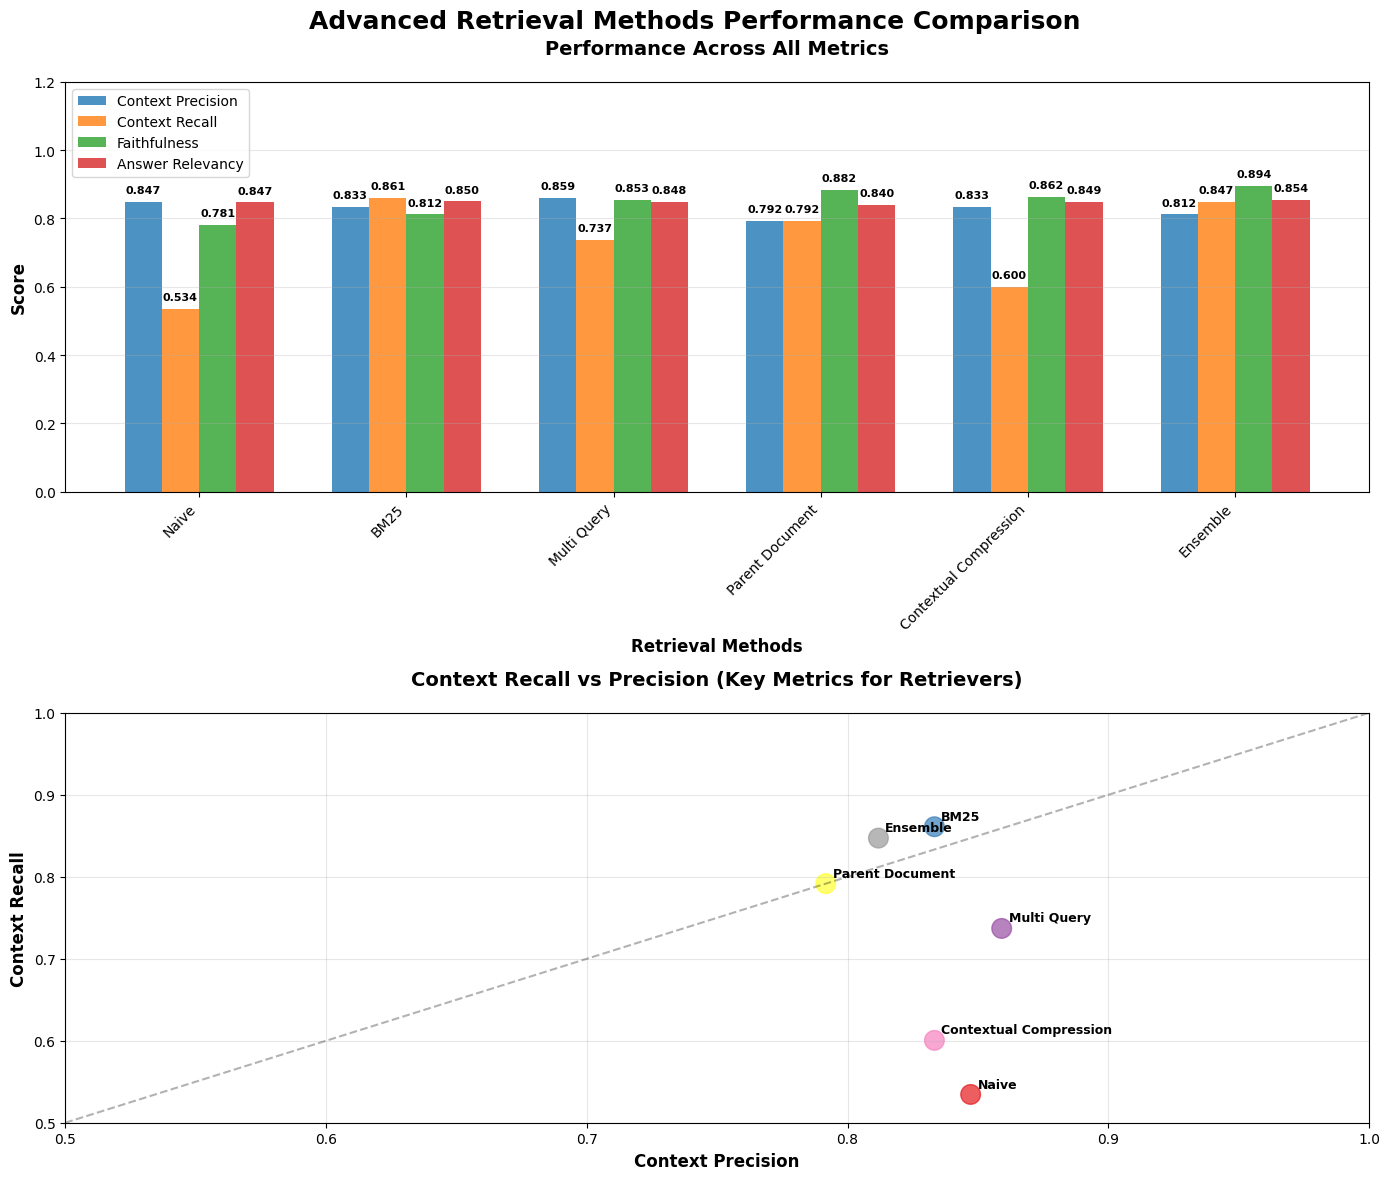


WHY THESE METRICS MATTER FOR RETRIEVERS:

Context Recall: Measures completeness - how much of the ground truth
information was actually retrieved. Critical because if the retriever
misses key facts, the LLM can't generate complete answers.

Context Precision: Measures relevance - how much of the retrieved
information was actually useful. Important because irrelevant context
can confuse the LLM and increase costs.

Retriever comparison complete! Evaluated 6 methods.
Best overall: Ensemble | Best recall: BM25 | Best precision: Multi Query


In [70]:
# RETRIEVER COMPARISON VISUALIZATION
# ==================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Set matplotlib backend for Jupyter
%matplotlib inline

# Set up clean plotting style
plt.style.use("default")
sns.set_palette("Set2")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

# Create a focused comparison visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
fig.suptitle(
    "Advanced Retrieval Methods Performance Comparison",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

# Prepare data
metrics = ["context_precision", "context_recall", "faithfulness", "answer_relevancy"]
metric_labels = [
    "Context Precision",
    "Context Recall",
    "Faithfulness",
    "Answer Relevancy",
]
df_comparison = pd.DataFrame(all_avg_scores).T
df_comparison = df_comparison.reindex(columns=metrics)

# 1. GROUPED BAR CHART - All metrics comparison
ax1.set_title("Performance Across All Metrics", fontsize=14, fontweight="bold", pad=20)

# Create grouped bar chart with more spacing
x = np.arange(len(df_comparison.index))
width = 0.18  # Slightly narrower bars for better spacing

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Clean, distinct colors

for i, metric in enumerate(metrics):
    offset = (i - 1.5) * width
    bars = ax1.bar(
        x + offset,
        df_comparison[metric],
        width,
        label=metric_labels[i],
        alpha=0.8,
        color=colors[i],
    )

    # Add value labels on bars with better positioning
    for j, bar in enumerate(bars):
        height = bar.get_height()
        # Position labels higher to avoid overlap
        label_y = height + 0.02
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            label_y,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

ax1.set_xlabel("Retrieval Methods", fontsize=12, fontweight="bold")
ax1.set_ylabel("Score", fontsize=12, fontweight="bold")
ax1.set_xticks(x)
ax1.set_xticklabels(df_comparison.index, rotation=45, ha="right")
ax1.legend(fontsize=10, loc="upper left")
ax1.set_ylim(0, 1.2)  # More space for labels
ax1.grid(True, alpha=0.3, axis="y")

# 2. CONTEXT RECALL vs PRECISION COMPARISON - Key metrics for retrievers
ax2.set_title(
    "Context Recall vs Precision (Key Metrics for Retrievers)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

# Create scatter plot comparing the two key metrics
x_pos = df_comparison["context_precision"]
y_pos = df_comparison["context_recall"]
retriever_names = df_comparison.index

# Create scatter plot with different colors for each retriever
colors_scatter = plt.cm.Set1(np.linspace(0, 1, len(retriever_names)))
scatter = ax2.scatter(x_pos, y_pos, s=200, alpha=0.7, c=colors_scatter)

# Add labels for each point
for i, name in enumerate(retriever_names):
    ax2.annotate(
        name,
        (x_pos.iloc[i], y_pos.iloc[i]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
    )

# Set axis limits first
ax2.set_xlim(0.5, 1.0)  # Focus on the data range
ax2.set_ylim(0.5, 1.0)  # Focus on the data range

# Add diagonal line for reference (equal recall and precision) within the visible range
ax2.plot([0.5, 1.0], [0.5, 1.0], "k--", alpha=0.3)

ax2.set_xlabel("Context Precision", fontsize=12, fontweight="bold")
ax2.set_ylabel("Context Recall", fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Add explanation text below the plots
print("\n" + "=" * 80)
print("WHY THESE METRICS MATTER FOR RETRIEVERS:")
print("=" * 80)
print()
print("Context Recall: Measures completeness - how much of the ground truth")
print("information was actually retrieved. Critical because if the retriever")
print("misses key facts, the LLM can't generate complete answers.")
print()
print("Context Precision: Measures relevance - how much of the retrieved")
print("information was actually useful. Important because irrelevant context")
print("can confuse the LLM and increase costs.")
print()
print("=" * 80)

# Calculate and display summary
best_recall = df_comparison["context_recall"].idxmax()
best_precision = df_comparison["context_precision"].idxmax()
best_overall = df_comparison.mean(axis=1).idxmax()

print(f"Retriever comparison complete! Evaluated {len(all_avg_scores)} methods.")
print(
    f"Best overall: {best_overall} | Best recall: {best_recall} | Best precision: {best_precision}"
)


## Comparison of Naive Chunking with Semantic Chunking

Step 1: Create Semantically Chunked Documents

In [71]:
# Create semantically chunked documents
from langchain_experimental.text_splitter import SemanticChunker

print("Creating semantically chunked documents...")

semantic_chunker = SemanticChunker(embeddings, breakpoint_threshold_type="percentile")

# Chunk the PDF documents semantically
pdf_docs_semantic = semantic_chunker.split_documents(pdf_docs)

print(f"✓ Regular chunks: {len(pdf_docs)} documents")
print(f"✓ Semantic chunks: {len(pdf_docs_semantic)} documents")
print(f"  Difference: {len(pdf_docs_semantic) - len(pdf_docs)} chunks")


Creating semantically chunked documents...
✓ Regular chunks: 64 documents
✓ Semantic chunks: 133 documents
  Difference: 69 chunks


Step 2:  Create Vectorstore with Semantic Chunks

In [73]:
# Create a new collection for semantic chunks
client.create_collection(
    collection_name="pdf_semantic_chunks",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

pdf_vectorstore_semantic = QdrantVectorStore(
    client=client,
    collection_name="pdf_semantic_chunks",
    embedding=embeddings,
)

_ = pdf_vectorstore_semantic.add_documents(documents=pdf_docs_semantic)

Step 3: Create Retriever with Semantic Chunks

In [74]:
# Create naive retriever with semantic chunks
naive_retriever_semantic = pdf_vectorstore_semantic.as_retriever(
    search_kwargs={"k": 10}
)

print("✓ Created naive retriever with semantic chunks")


✓ Created naive retriever with semantic chunks


Step 4: Evaluate and Compare

In [75]:

import pandas as pd

# Evaluate semantic chunking retriever
print(f"\n{'=' * 70}")
print("🔄 Evaluating NAIVE (SEMANTIC CHUNKING) retriever")
print(f"{'=' * 70}")

rag_chain_semantic = rag_chain_for_retriever(
    naive_retriever_semantic, rag_prompt, chat_model
)
result_semantic = evaluate_retriever(
    "Naive (Semantic)", rag_chain_semantic, evaluation_dataset
)
avg_scores_semantic = display_results("Naive (Semantic)", result_semantic)

# Compare with regular naive retriever
print("\n" + "=" * 70)
print("🔍 SEMANTIC CHUNKING COMPARISON")
print("=" * 70)

comparison_semantic = pd.DataFrame(
    {
        "Regular Chunking": all_avg_scores["Naive"],
        "Semantic Chunking": avg_scores_semantic,
    }
)

print(comparison_semantic.round(4).to_string())

# Calculate improvement
print("\n📈 IMPROVEMENT:")
print("-" * 70)
for metric in comparison_semantic.index:
    regular = comparison_semantic.loc[metric, "Regular Chunking"]
    semantic = comparison_semantic.loc[metric, "Semantic Chunking"]
    improvement = ((semantic - regular) / regular) * 100
    symbol = "📈" if improvement > 0 else "📉" if improvement < 0 else "➡️"
    print(f"  {metric:25s}: {improvement:+.2f}% {symbol}")



🔄 Evaluating NAIVE (SEMANTIC CHUNKING) retriever
Evaluating Naive (Semantic)...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: NAIVE (SEMANTIC)

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.7894 (78.94%)
  context_recall           : 0.7500 (75.00%)
  faithfulness             : 0.7774 (77.74%)
  answer_relevancy         : 0.8478 (84.78%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          0.0000        0.0000            0.0000
2                   1.0000          1.0000        1.0000            0.8940
3                   1.0000          1.0000        0.9259            0.9549
4                   0.0000          0.0000        1.0000            0.9328
5                   1.0000          1.0000        0.6731            0.9190
6                   1.0000          1.0000        0.8